# Utils

In [1]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import networkx as nx
import numpy as np
import torch
from random import randint

def create_dataset():
    Gs = list()
    y = list()

    ############## Task 1
    p_1 = 0.2
    p_2 = 0.4
    
    for i in range(50):
        n = randint(10, 20)
        Gs.append(nx.fast_gnp_random_graph(n, p_1))
        y.append(0)
        m = randint(10, 20)
        Gs.append(nx.fast_gnp_random_graph(m, p_2))
        y.append(1)

    return Gs, y


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)


# Models

In [2]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        
        ############## Task 2

        x = self.fc1(x_in)
        x = self.relu(torch.mm(adj, x))

        x = self.fc2(x)
        x = self.relu(torch.mm(adj,x))
        
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1), device=x_in.device)
        out = out.scatter_add_(0, idx, x) 

        out = self.relu(self.fc3(out))
        out = self.fc4(out)

        return F.log_softmax(out, dim=1)


# GNN

In [3]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
"""

import time
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim

# from part1.models import GNN
# from part1.utils import create_dataset, sparse_mx_to_torch_sparse_tensor
# from part1.models import GNN

# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()



In [10]:
# Trains the model
train_losses = []
train_accs = []

for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()

        for j in range(i, min(N_train, i+batch_size)):
            n = G_train[j].number_of_nodes()
            adj_batch.append(nx.adjacency_matrix(G_train[j])+sp.identity(n))
            idx_batch.extend([j-i]*n)
            y_batch.append(y_train[j])
        
        adj_batch = sp.block_diag(adj_batch)
        features_batch = np.ones((adj_batch.shape[0],1))

        adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
        features_batch = torch.FloatTensor(features_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)

        ############## Task 3
        
        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    train_losses.append(train_loss/count)
    train_accs.append(correct/count)
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')



Epoch: 0001 loss_train: 0.1828 acc_train: 0.9111 time: 0.0509s
Epoch: 0011 loss_train: 0.1816 acc_train: 0.9111 time: 0.0226s
Epoch: 0021 loss_train: 0.2020 acc_train: 0.8889 time: 0.0226s
Epoch: 0031 loss_train: 0.1445 acc_train: 0.8889 time: 0.0247s
Epoch: 0041 loss_train: 0.1491 acc_train: 0.9111 time: 0.0235s
Epoch: 0051 loss_train: 0.1490 acc_train: 0.9333 time: 0.0238s
Epoch: 0061 loss_train: 0.1636 acc_train: 0.9111 time: 0.0224s
Epoch: 0071 loss_train: 0.1437 acc_train: 0.9111 time: 0.0237s
Epoch: 0081 loss_train: 0.1394 acc_train: 0.9222 time: 0.0230s
Epoch: 0091 loss_train: 0.1017 acc_train: 0.9556 time: 0.0236s
Epoch: 0101 loss_train: 0.1029 acc_train: 0.9556 time: 0.0230s
Epoch: 0111 loss_train: 0.1401 acc_train: 0.9222 time: 0.0232s
Epoch: 0121 loss_train: 0.0611 acc_train: 0.9667 time: 0.0229s
Epoch: 0131 loss_train: 0.0716 acc_train: 0.9667 time: 0.0235s
Epoch: 0141 loss_train: 0.0609 acc_train: 0.9778 time: 0.0228s
Epoch: 0151 loss_train: 0.0549 acc_train: 0.9778 time: 

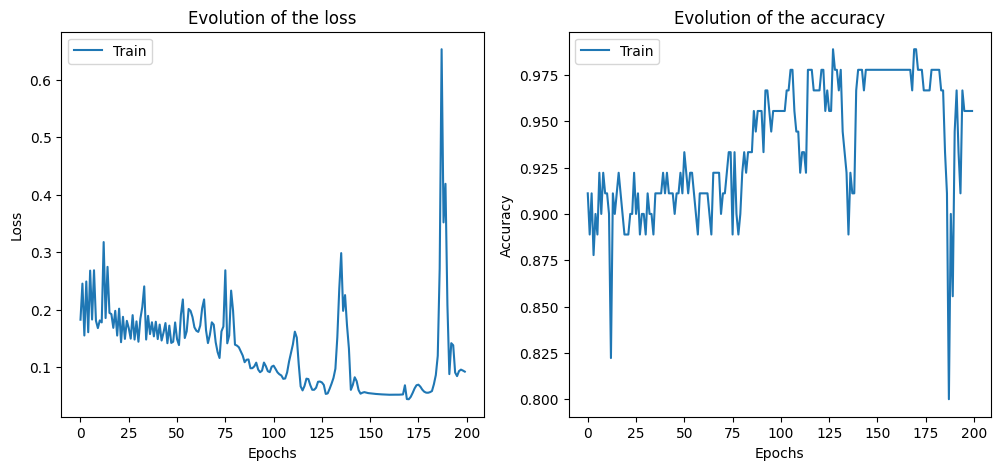

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs), train_losses, label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Evolution of the loss')
ax[0].legend()
ax[1].plot(range(epochs), train_accs, label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Evolution of the accuracy')
ax[1].legend()
plt.show()

In [13]:
# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0

for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 3

    for j in range(i, min(N_test, i+batch_size)):
        n = G_test[j].number_of_nodes()
        adj_batch.append(nx.adjacency_matrix(G_test[j])+sp.identity(n))
        idx_batch.extend([j-i]*n)
        y_batch.append(y_test[j])
    
    adj_batch = sp.block_diag(adj_batch)
    features_batch = np.ones((adj_batch.shape[0],1))

    adj_batch = sparse_mx_to_torch_sparse_tensor(adj_batch).to(device)
    features_batch = torch.FloatTensor(features_batch).to(device)
    idx_batch = torch.LongTensor(idx_batch).to(device)
    y_batch = torch.LongTensor(y_batch).to(device)

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))

loss_test: 0.1680 acc_test: 0.9000 time: 110.8697s
